# Email Spam Classication 📧

### Context

The focus of this project is to gain hands-on experience with classification modules in supervised learning. With this in mind the I intend to classify an email as spam or ham (not spam), to do so I found a raw file [here](http://www2.aueb.gr/users/ion/data/enron-spam/). It contains two folders of spam and ham. Each folder contains emails. I iterated to each text file of those folders and created a data frame and written to a CSV file, that is available in this directory. In the data set the spam as label "1" and the ham as label "0".

Legitimate
----------
- Owner: farmer-d
- Total number: 3672 emails
- Date of first email: 1999-12-10
- Date of last email: 2002-01-11
- Similars deletion: No
- Encoding: No


Spam
----
- Owner: GP
- Total number: 1500 emails
- Date of first email: 2003-12-18
- Date of last email: 2005-09-06
- Similars deletion: No
- Encoding: No

Spam:Legitimate rate = 1:3
Total number of emails (legitimate + spam): 5975


### Table of Content 
1. [Firt Look](#First_look)
    1. [Download_Files](#Downlod)

    2. [Imports](#Imports)
     
    3. [Data Cleaning](#Data_Cleaning)
    
    4. [Data Analise](#Data_Analise)

2. [Classification Models](#Classification)

    1. [Naive Bayes](#Naive_Bayes)
    2. [Support Vector Machines](#Support_Vector_Machines)
    3. [Random Forests (Bagging)](#Random_Forests_(Bagging))
    4. [K-Nearest Neighbor](#K-Nearest_Neighbor )
    5. [Gradboosting](#Gradboosting)
    6. [GridSearchCV](#GridSearchCV)
    6. [Logistic Regression](#Logistic_Regression)
    7. [Desission tree](#Desission_tree)

## First_look

### Imports

In [62]:
#files
import urllib.request
import os
import tarfile
import pickle
import shutil
import re
from string import punctuation
import warnings


#data manipulation and plots
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

#words 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 



# sklearn models and classifiers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import feature_extraction,model_selection

#metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, r2_score,mean_squared_error



### Download

In [2]:
# Get the user's Current folder path
CURR_DIR = os.path.dirname(os.path.realpath(" "))

In [3]:
print("Downloading Enron emails in the Downloads folder...")

# Get the user's Downloads folder path
downloads = os.path.join(os.environ['HOME'] + "/Downloads")

url = "http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/"

enron_dir = os.path.join(downloads, 'Enron emails')

enron_files = ['enron1.tar.gz', 'enron2.tar.gz', 'enron3.tar.gz',
               'enron4.tar.gz', 'enron5.tar.gz', 'enron6.tar.gz']

def download():
    """ Download Enron emails if missing. """
    
    # Create the directories.
    if not os.path.exists(enron_dir):
        os.makedirs(enron_dir)
    # Download the files that not exist.
    for file in enron_files:
        path = os.path.join(enron_dir, file)
        if not os.path.exists(path):
            urllib.request.urlretrieve(url + file, path)

def extract_emails(fname):
    """ Extract the zipped emails and load them into a pandas df.
    Args:
        fname (str): the files with tar.gz extension
    Returns:
        pandas df: a pandas dataframe of emails
    """
    
    rows = []
    tfile = tarfile.open(fname, 'r:gz')
    for member in tfile.getmembers():
        if 'ham' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'email': row, 'class': 'ham'})
        if 'spam' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'email': row, 'class': 'spam'})
    tfile.close()
    return pd.DataFrame(rows)

def populate_df_and_pickle():
    """ Populate the df with all the emails and save it to a pickle object. """
    
    if not os.path.exists(downloads + "/emails.pickle"):
        emails_df = pd.DataFrame({'email': [], 'class': []})
        for file in enron_files:
            unzipped_file = extract_emails(os.path.join(enron_dir, file))
            emails_df = emails_df.append(unzipped_file)
        emails_df.to_pickle(downloads + "/emails.pickle")

if __name__ == '__main__':
    download()
    populate_df_and_pickle()
    print("Download, unzip, and save to pickle done!")
    #move files from downloads to current working directory
    data_pickle = downloads + '/emails.pickle'
    dirt = shutil.move(data_pickle, CURR_DIR+ '/emails.pickle')
    print("Pickle moved to current working directory {}.".format(dirt))
    rem  = shutil.rmtree(enron_dir) 
    print("Enron zip deleted {}.".format(enron_dir))

Download, unzip, and save to pickle done!
Pickle moved to current working directory /Users/sousa/Desktop/IBM_ML_course/MachineLearning_IBM/Supervised_Learning_Classification/Project/emails.pickle.
Enron zip deleted /Users/sousa/Downloads/Enron emails.


In [4]:
with open(CURR_DIR + '/emails.pickle', 'rb') as f:
    emails_df = pickle.load(f) 

# Translate bytes objects into strings.
emails_df['email'] = emails_df['email'].apply(lambda x: x.decode('latin-1'))

# Reset pandas df index.
emails_df = emails_df.reset_index(drop=True)

# Map 'spam' to 1 and 'ham' to 0.
emails_df['class'] = emails_df['class'].map({'spam':1, 'ham':0})

print(emails_df.index)
emails_df.shape

RangeIndex(start=0, stop=33716, step=1)


(33716, 2)

In [5]:
emails_df.iloc[25000].values

array(["Subject: [ ilug - social ] prirodu requiremus social sample\r\nsocial\r\non january lst 2002 , the european countries began\r\nusing the new euro . never before have so\r\nmany countries with such powerful economies united\r\nto use a single currency . get your piece of history\r\nnow ! we would like to send you a free euro\r\nand a free report on world currency . just visit\r\nour site to request your euro and euro report :\r\nin addition to our currency report , you can receive\r\nour free investment package :\r\n* learn how $ 10 , 000 in options will leverage $ 1 , 000 , 000 in\r\neuro currency . this means even a small movement in the market\r\nhas huge profit potential . csice\r\nif you are over age 18 and have some risk capital , it ' s\r\nimportant that you find out how the euro will\r\nchange the economic world and how you can profit !\r\nplease carefully evaluate your financial position before\r\ntrading . only risk capital should be used .\r\n8 c 43 fd 25 cb 6 f 94994

### Data_Cleaning

Remove the punctuation, any urls and numbers. Finally, convert every word to lower case.

In [63]:
def clean_email(email):
    """ Remove all punctuation, urls, numbers, and newlines.
    Convert to lower case.
    Args:
        email (unicode): the email
    Returns:
        email (unicode): only the text of the email
    """
    
    email = re.sub(r'http\S+', ' ', email)
    email = re.sub("\d+", " ", email)
    email = email.replace('\n', ' ')
    email = email.translate(str.maketrans("", "", punctuation))
    email = email.lower()
    return email

emails_df['email'] = emails_df['email'].apply(clean_email)

emails_df.iloc[25000].values

array(['subject ilug social prirodu requiremus social sampl social on januari lst the european countri began use the new euro never befor have so mani countri with such power economi unit to use a singl currenc get your piec of histori now we would like to send you a free euro and a free report on world currenc just visit our site to request your euro and euro report in addit to our currenc report you can receiv our free invest packag learn how in option will leverag in euro currenc this mean even a small movement in the market has huge profit potenti csice if you are over age and have some risk capit it s import that you find out how the euro will chang the econom world and how you can profit pleas care evalu your financi posit befor trade onli risk capit should be use c fd cb f eel c e utbxcuhepuffbnkwq full opt out instruct on the bottom of the site irish linux user group social event social linux ie http www linux ie mailman listinfo social for un subscript inform list maintain lis

### Prepare the Data
--------------------

Split the text string into individual words and stem each word. Remove english stop words.

##### Split and Stem
-----------------


Split the text by white spaces and link the different forms of the same word to each other, using stemming. For example “responsiveness” and “response” have the same stem/root - “respons”.

##### Remove Stop Words
------------------------

Some words such as “the” or “is” appear in all emails and don’t have much content to them. These words are not going to help the algorithm distinguish spam from ham. Such words are called stopwords and they can be disregarded during classification.

In [7]:
from nltk.stem.snowball import SnowballStemmer
# nltk.download('wordnet') # uncomment to download 'wordnet'
from nltk.corpus import wordnet as wn

def preproces_text(email):
    """ Split the text string into individual words, stem each word,
    and append the stemmed word to words. Make sure there's a single
    space between each stemmed word.
    Args:
        email (unicode): the email
    Returns:
        words (unicode): the text of the email
    """
    
    words = ""
    # Create the stemmer.
    stemmer = SnowballStemmer("english")
    # Split text into words.
    email = email.split()
    for word in email:
        # Optional: remove unknown words.
        # if wn.synsets(word):
        words = words + stemmer.stem(word) + " "
    
    return words

emails_df['email'] = emails_df['email'].apply(preproces_text)

emails_df.iloc[25000].values

array(['subject ilug social prirodu requiremus social sampl social on januari lst the european countri began use the new euro never befor have so mani countri with such power economi unit to use a singl currenc get your piec of histori now we would like to send you a free euro and a free report on world currenc just visit our site to request your euro and euro report in addit to our currenc report you can receiv our free invest packag learn how in option will leverag in euro currenc this mean even a small movement in the market has huge profit potenti csice if you are over age and have some risk capit it s import that you find out how the euro will chang the econom world and how you can profit pleas care evalu your financi posit befor trade onli risk capit should be use c fd cb f eel c e utbxcuhepuffbnkwq full opt out instruct on the bottom of the site irish linux user group social event social linux ie http www linux ie mailman listinfo social for un subscript inform list maintain lis

#### Data_Analise

In [8]:
data = emails_df

In [9]:
data.head(5)

,email,class
0,subject christma tree farm pictur,0
1,subject vastar resourc inc gari product from t...,0
2,subject calpin daili gas nomin calpin daili ga...,0
3,subject re issu fyi see note below alreadi don...,0
4,subject meter nov alloc fyi forward by lauri a...,0


In [10]:
print("In this data frame there are {} emails from witch {} are spam and {} are ham "
      .format(len(data), len(data[data['class']==1]),len(data[data['class']==0]) ) )

In this data frame there are 33716 emails from witch 17171 are spam and 16545 are ham 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

Text(0.5, 1.0, 'Pie chart')

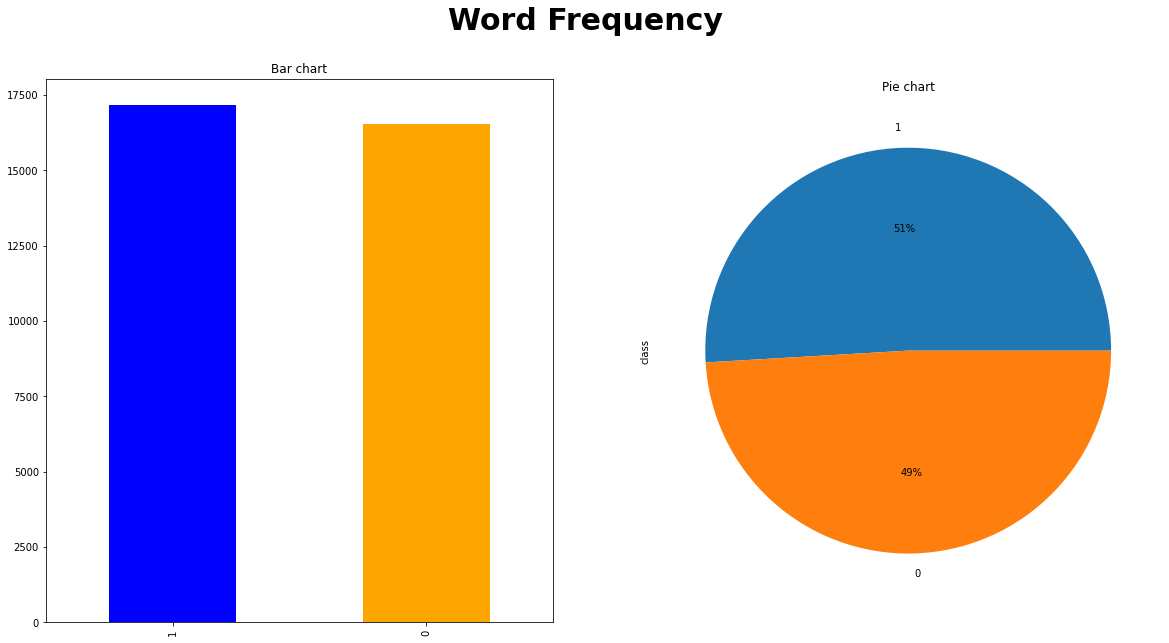

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Word Frequency', fontsize = 30, fontweight='bold')

count_Class=pd.value_counts(data["class"], sort= True)
ax = count_Class.plot(kind= 'bar', color= ["blue", "orange"], ax=axs[0])
ax.set_title('Bar chart')

ax = count_Class.plot(kind = 'pie',  autopct='%1.0f%%', ax=axs[1])
ax.set_title('Pie chart')


[nltk_data] Downloading package stopwords to /Users/sousa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sousa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


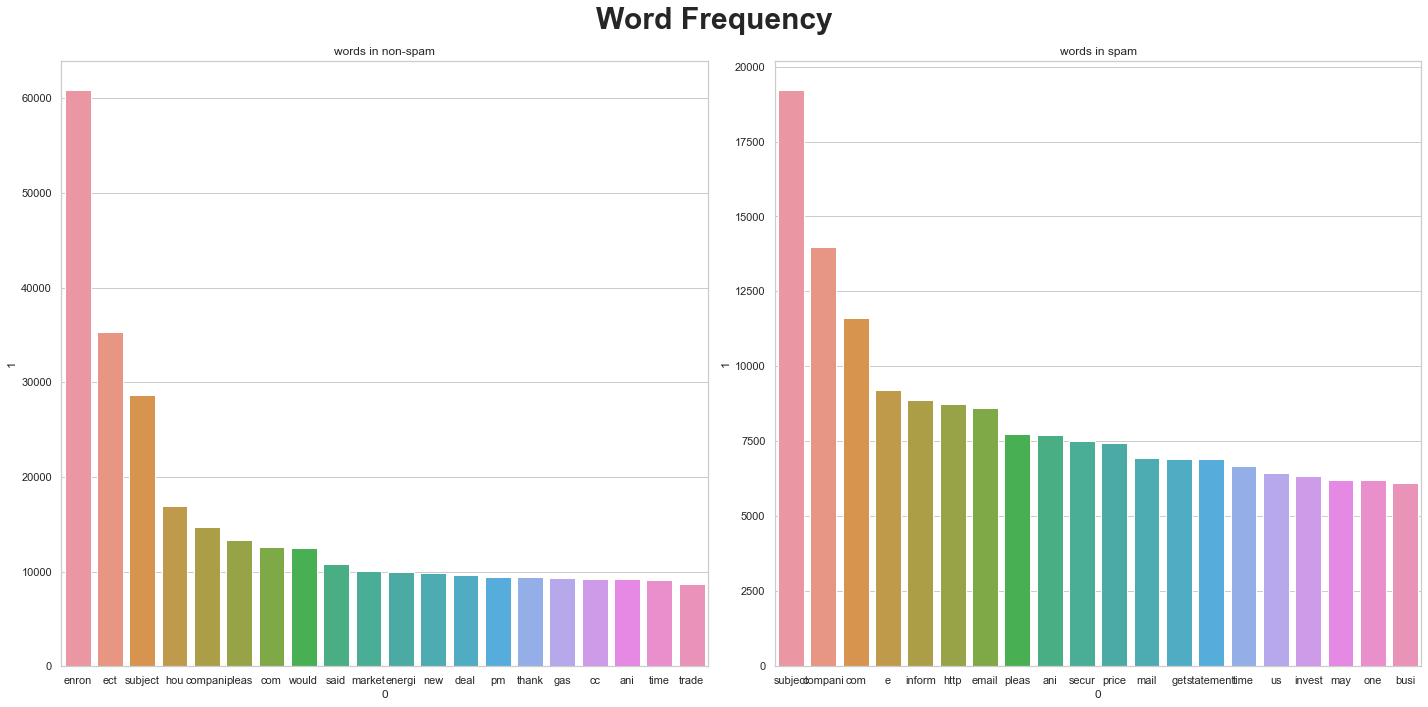

In [93]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
data1 = "".join(data[data['class']==0]['email']).split() 
data1 = [w for w in data1 if not w in stop_words]
data1 = Counter(data1).most_common(20)
df1 = pd.DataFrame(data1)

data2 = "".join(data[data['class']==1]['email']).split() 
data2 = [w for w in data2 if not w in stop_words]
data2 = Counter(data2).most_common(20)
df2 = pd.DataFrame(data2)

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Word Frequency', fontsize = 30, fontweight='bold')


ax1 = sns.barplot(x=df1[0],y=df1[1], data=df1, ax=axs[0])
ax1.set_title("words in non-spam")


ax2 = sns.barplot(x=df2[0],y=df2[1],data=df2,ax=axs[1])
ax2.set_title("words in spam")

plt.tight_layout()

#### Remove all english stop words

In [130]:
data23 = data
for i in range(len(data)):
    for j in data23['email'][i].split(): 
        if j in stop_words:
            data23['email'][i].replace(j,"")

In [141]:
data23.iloc[25000].values

array(['subject ilug social prirodu requiremus social sampl social on januari lst the european countri began use the new euro never befor have so mani countri with such power economi unit to use a singl currenc get your piec of histori now we would like to send you a free euro and a free report on world currenc just visit our site to request your euro and euro report in addit to our currenc report you can receiv our free invest packag learn how in option will leverag in euro currenc this mean even a small movement in the market has huge profit potenti csice if you are over age and have some risk capit it s import that you find out how the euro will chang the econom world and how you can profit pleas care evalu your financi posit befor trade onli risk capit should be use c fd cb f eel c e utbxcuhepuffbnkwq full opt out instruct on the bottom of the site irish linux user group social event social linux ie http www linux ie mailman listinfo social for un subscript inform list maintain lis

In [132]:

data = data23

In [133]:
X = data['email'].values
Y = data['class'].values
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X = vectorizer.fit_transform(X)


In [134]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42,shuffle=True,)
print([np.shape(train_x), np.shape(test_x)])

[(22589, 119405), (11127, 119405)]


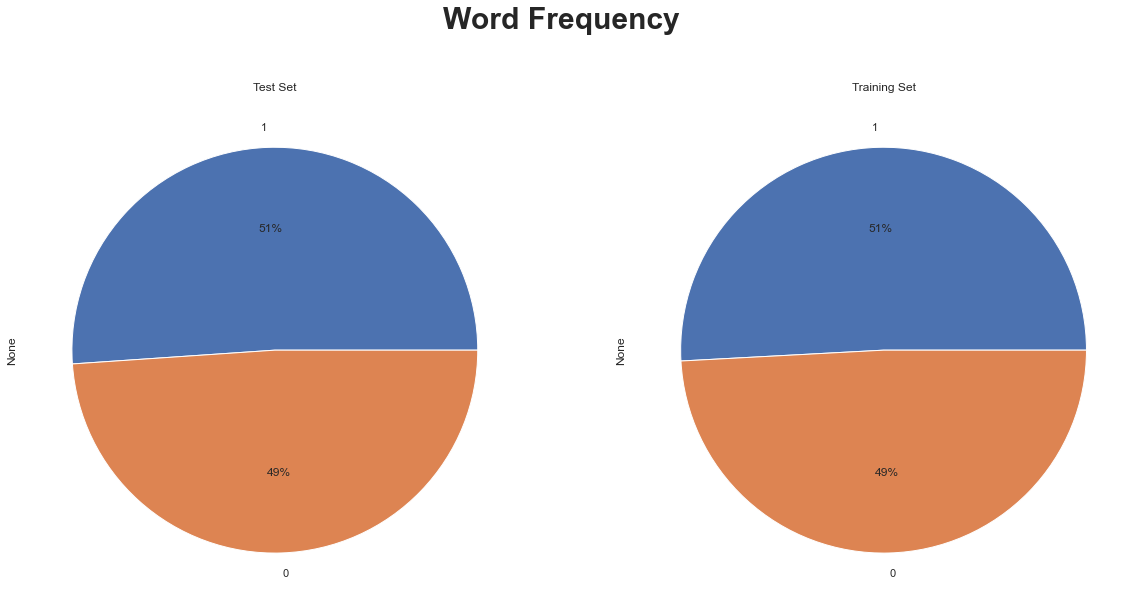

In [135]:
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Word Frequency', fontsize = 30, fontweight='bold')

count_Class = pd.value_counts(test_y, sort= True)
ax = count_Class.plot(kind = 'pie',  autopct='%1.0f%%', ax=axs[0])
ax.set_title("Test Set")

count_Class = pd.value_counts(train_y, sort= True)
ax = count_Class.plot(kind = 'pie',  autopct='%1.0f%%', ax=axs[1])
ax.set_title("Training Set")

plt.show()

------
As we can se the proporsionality of the initial data is mantained 51 / 49

## Classification 

## Naive_Bayes

In [136]:
# Create classifier.
clf = MultinomialNB()

# Fit the classifier on the training features and labels.
clf.fit(train_x, train_y)

# Make prediction - Store predictions in a list named pred.
y_pred1 = clf.predict(test_x)


print(classification_report(test_y, y_pred1))
print('Accuracy Score of Naive Bayes : ', round(accuracy_score(test_y, y_pred1), 2))
print('F1 Score of Naive Bayes  : ', round(f1_score(test_y, y_pred1), 2))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5443
           1       0.99      0.98      0.99      5684

    accuracy                           0.99     11127
   macro avg       0.99      0.99      0.99     11127
weighted avg       0.99      0.99      0.99     11127

Accuracy Score of Naive Bayes :  0.99
F1 Score of Naive Bayes  :  0.99


##### Identify the Most Powerful Features

-------------------------------------------
Print the 10 most important features.

In [17]:
#this give the most important features
def get_most_important_features(vectorizer, classifier, n=None):
    feature_names = vectorizer.get_feature_names()
    top_features = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    for coef, feat in top_features:
        print(coef, feat)

In [18]:
get_most_important_features(vectorizer, clf, 10)

-7.198575032207408 price
-7.190035073094052 money
-7.1772213452582205 onlin
-7.168634129556926 softwar
-7.166961093096661 www
-7.1484680064830215 offer
-7.085199046392926 email
-7.04755691770725 click
-6.779235753921363 com
-6.702829887086776 http


## Support_Vector_Machines

Support Vector Machine is the most sought after algorithm for classic classification problems. SVMs work on the algorithm of Maximal Margin, i.e, to find the maximum margin or threshold between the support vectors of the two classes (in binary classification). The most effective Support vector machines are the soft maximal margin classifier, that allows one misclassification, i.e, the model starts with low bias(slightly poor performance) to ensure low variance later.

In [25]:
C=0.1
svc = svm.SVC(C,'linear')         
svc.fit(train_x,train_y)
y_pred2 = svc.predict(test_x)


print(classification_report(test_y, y_pred2))
print('Accuracy Score of SVC: ', round(accuracy_score(test_y, y_pred2), 2))
print('F1 Score of SVC : ', round(f1_score(test_y, y_pred2), 2))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      5443
           1       0.96      1.00      0.98      5684

    accuracy                           0.98     11127
   macro avg       0.98      0.98      0.98     11127
weighted avg       0.98      0.98      0.98     11127

Accuracy Score of SVC:  0.98
F1 Score of SVC :  0.98


## Random_Forests_(Bagging)
Ensemble methods turn any feeble model into a highly powerful one. Let us see if ensemble model can perform better than Naive Bayes

In [26]:
rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
# n_estimators = No. of trees in the forest
# criterion = basis of making the decision tree split, either on gini impurity('gini'), or on infromation gain('entropy')
rfc.fit(train_x,train_y)
y_pred3 = rfc.predict(test_x)


print(classification_report(test_y, y_pred3))
print('Accuracy Score of Random Forest Classifier : ', round(accuracy_score(test_y, y_pred3), 2))
print('F1 Score of Random Forest Classifier: ', round(f1_score(test_y, y_pred3), 2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5443
           1       0.98      0.99      0.99      5684

    accuracy                           0.99     11127
   macro avg       0.99      0.99      0.99     11127
weighted avg       0.99      0.99      0.99     11127

Accuracy Score of Random Forest Classifier :  0.99
F1 Score of Random Forest Classifier:  0.99




As expected, Random Forest Classifier performs the best among the three. Decision tree classifiers are excellent classifiers. Random forest is a popular ensemble model that uses a forest of decision trees. So, obviously, combibining the accuracy of 100 trees (as n_estimators=100 here), will create a powerful model.


## K-Nearest_Neighbor 


In [137]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(train_x, train_y)
y_pred4 = knn.predict(test_x)
# Preciision, recall, f-score from the multi-class support function

print(classification_report(test_y, y_pred4))
print('Accuracy Score of KNeighbors: ', round(accuracy_score(test_y, y_pred4), 2))
print('F1 Score of KNeighbors: ', round(f1_score(test_y, y_pred4), 2))

              precision    recall  f1-score   support

           0       1.00      0.34      0.51      5443
           1       0.61      1.00      0.76      5684

    accuracy                           0.68     11127
   macro avg       0.81      0.67      0.63     11127
weighted avg       0.80      0.68      0.64     11127

Accuracy Score of KNeighbors:  0.68
F1 Score of KNeighbors:  0.76


In [138]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(train_x, train_y)
    
    y_pred = knn.predict(test_x)
    f1 = f1_score(y_pred, test_y)
    f1_scores.append((k, round(f1_score(test_y, y_pred), 4)))
    error = 1-round(accuracy_score(test_y, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

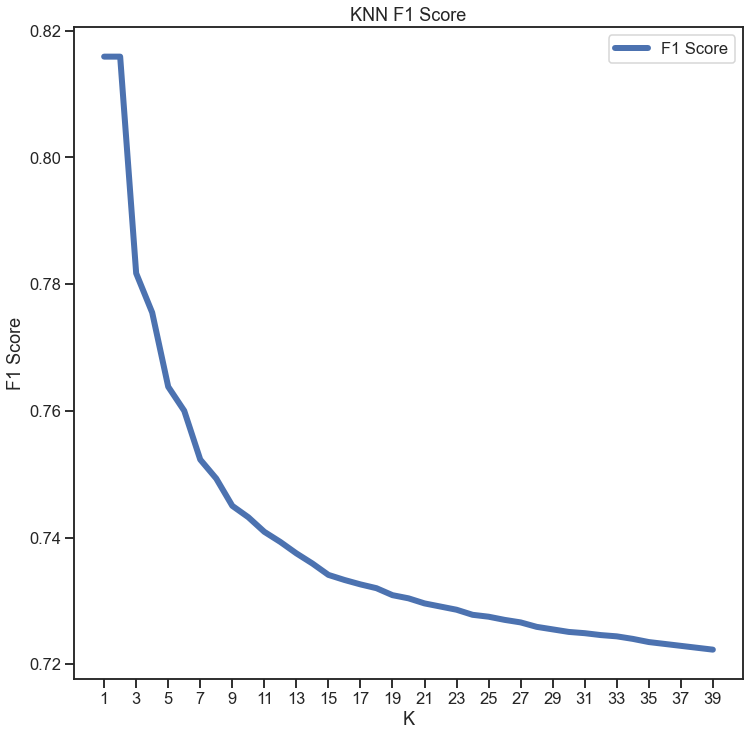

In [139]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(color="b", figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 600x400 with 0 Axes>

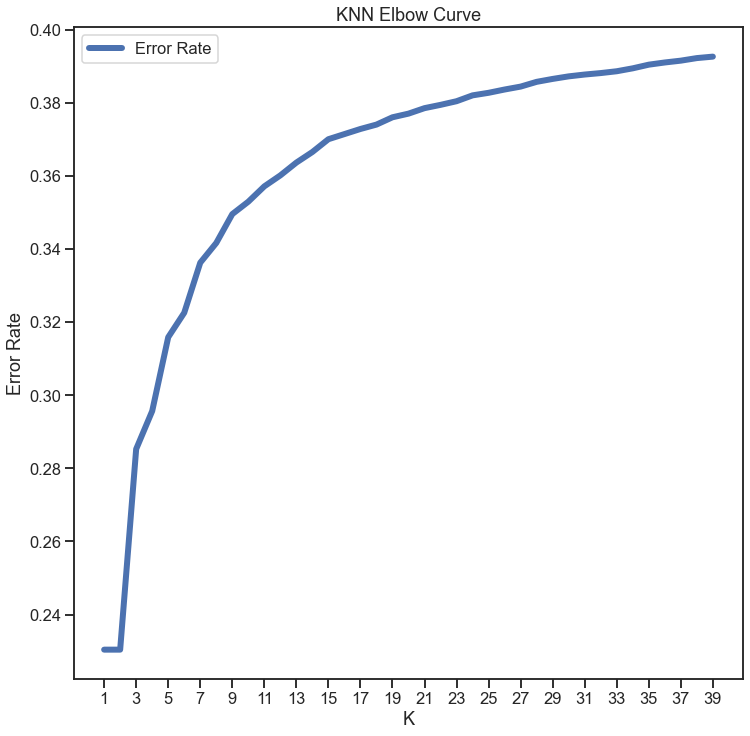

In [140]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=100)
ax = error_results.set_index('K').plot(color="b", figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

## Gradboosting

In [41]:
error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(train_x, train_y)
    y_pred5 = GBC.predict(test_x)

    # Get the error
    error = 1.0 - accuracy_score(test_y, y_pred5)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


,error
n_trees,
15.0,0.134897
25.0,0.101824
50.0,0.074144
100.0,0.054462
200.0,0.038914
400.0,0.029747


In [43]:
print(classification_report(test_y, y_pred5))
print('Accuracy Score of KNeighbors: ', round(accuracy_score(test_y, y_pred5), 2))
print('F1 Score of KNeighbors: ', round(f1_score(test_y, y_pred5), 2))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      5443
           1       0.95      1.00      0.97      5684

    accuracy                           0.97     11127
   macro avg       0.97      0.97      0.97     11127
weighted avg       0.97      0.97      0.97     11127

Accuracy Score of KNeighbors:  0.97
F1 Score of KNeighbors:  0.97


## GridSearchCV

In [44]:
# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(train_x, train_y)


In [45]:
GV_GBC.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [46]:
y_pred6 = GV_GBC.predict(test_x)

print(classification_report(test_y, y_pred6))
print('Accuracy Score of KNeighbors: ', round(accuracy_score(test_y, y_pred6), 2))
print('F1 Score of KNeighbors: ', round(f1_score(test_y, y_pred6), 2))

              precision    recall  f1-score   support

           0       0.87      0.54      0.67      5443
           1       0.68      0.92      0.78      5684

    accuracy                           0.73     11127
   macro avg       0.77      0.73      0.72     11127
weighted avg       0.77      0.73      0.72     11127

Accuracy Score of KNeighbors:  0.73
F1 Score of KNeighbors:  0.78


## Logistic_Regression

In [47]:
# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(train_x, train_y)
y_pred7 = LR_L2.predict(test_x)
print(classification_report(y_pred7, test_y))
print('Accuracy Score of KNeighbors: ', round(accuracy_score(test_y, y_pred7), 2))
print('F1 Score of KNeighbors: ', round(f1_score(test_y, y_pred7), 2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5307
           1       1.00      0.97      0.98      5820

    accuracy                           0.98     11127
   macro avg       0.98      0.98      0.98     11127
weighted avg       0.98      0.98      0.98     11127

Accuracy Score of KNeighbors:  0.98
F1 Score of KNeighbors:  0.98


## Desission_tree 

In [48]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(train_x, train_y)

y_pred8 = dt.predict(test_x)
print(classification_report(y_pred8, test_y))
print('Accuracy Score of KNeighbors: ', round(accuracy_score(test_y, y_pred8), 2))
print('F1 Score of KNeighbors: ', round(f1_score(test_y, y_pred8), 2))



              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5435
           1       0.96      0.96      0.96      5692

    accuracy                           0.96     11127
   macro avg       0.96      0.96      0.96     11127
weighted avg       0.96      0.96      0.96     11127

Accuracy Score of KNeighbors:  0.96
F1 Score of KNeighbors:  0.96


# Conclusion

In [51]:
from prettytable import PrettyTable

In [58]:
warnings.filterwarnings('ignore')
ptbl = PrettyTable()
ptbl.field_names = ["Classification Model", "Precision", "Accuracy", "Root Mean Square Error"]

ptbl.add_row(["Naive Bayes", r2_score(test_y,y_pred1), accuracy_score(test_y, y_pred1) ,np.sqrt(mean_squared_error(test_y, y_pred1))])

ptbl.add_row(["Support Vector Machines", r2_score(test_y,y_pred2), accuracy_score(test_y, y_pred2) ,np.sqrt(mean_squared_error(test_y, y_pred2))])

ptbl.add_row(["Random Forests (Bagging)", r2_score(test_y,y_pred3), accuracy_score(test_y, y_pred3) ,np.sqrt(mean_squared_error(test_y, y_pred3))])

ptbl.add_row(["K-Nearest Neighbor", r2_score(test_y,y_pred4), accuracy_score(test_y, y_pred4) ,np.sqrt(mean_squared_error(test_y, y_pred4))])
            
ptbl.add_row(["Gradboosting", r2_score(test_y,y_pred5), accuracy_score(test_y, y_pred5) ,np.sqrt(mean_squared_error(test_y, y_pred5))])            

ptbl.add_row(["GridSearchCV", r2_score(test_y,y_pred6), accuracy_score(test_y, y_pred6) ,np.sqrt(mean_squared_error(test_y, y_pred6))])

ptbl.add_row(["Logistic Regression", r2_score(test_y,y_pred7), accuracy_score(test_y, y_pred7) ,np.sqrt(mean_squared_error(test_y, y_pred7))])

ptbl.add_row(["Desission_tree", r2_score(test_y,y_pred8), accuracy_score(test_y, y_pred8) ,np.sqrt(mean_squared_error(test_y, y_pred8))])

print(ptbl)

+--------------------------+-----------------------+--------------------+------------------------+
|   Classification Model   |       Precision       |      Accuracy      | Root Mean Square Error |
+--------------------------+-----------------------+--------------------+------------------------+
|       Naive Bayes        |   0.9417359460588483  | 0.9854408196279321 |  0.12066142868401626   |
| Support Vector Machines  |   0.9075687539328642  | 0.9769030286690034 |   0.1519768776195796   |
| Random Forests (Bagging) |   0.9518062763696646  | 0.9879572211737215 |  0.10973959552631138   |
|    K-Nearest Neighbor    |  -0.29511640890177415 | 0.6763727869147119 |   0.5688824246584596   |
|       Gradboosting       |   0.8809543095399924  | 0.9702525388694168 |  0.17247452313481915   |
|       GridSearchCV       | -0.061700538483209666 | 0.7346993798867619 |   0.5150734123532664   |
|   Logistic Regression    |   0.9352621622876092  | 0.9838231329199245 |  0.12718831345715492   |
|      Des

As we can see in the table above and in the other reports presented in the notebook, all the models seem to preform well this classification task. Nevertheless  Random Forests (Bagging) seams to be the one with best results. 

All the performance cold be improved with a better data cleaning process, for example creating clusters to divide the to classes and removing repeated words.

Language Processing was and will always be huge portion of our modern world technology, nowadays we use AI and Machine Learning for Natural Language Processing, Machine Translation etc. In this project I had the chance to play with different tips of ML algorithms for classifying English Emails as Spam or not spam. In the future it would be interesting to optimize this project to identify spam or not spam different Languages and not only in English. 